In [163]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

import xgboost

In [164]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1) Read in data & explore preliminarily

In [165]:
df = pd.read_csv('home_sales_dataset.csv')
print(df.shape)
df.head()

(1011, 18)


,sold_price,beds,baths,hm_sqft,lot_size,yr_built,zipcode,pool,garage,stories,schools,sold_date,address,days_on_mkt,hoa,url,lat,lon
0,970000,4,3.0,1933,6999,1960,91364,1,1,1,6.4,August-24-2021,22247 De La Osa St,3,0,http://www.redfin.com/CA/Woodland-Hills/22247-...,34.159168,-118.611596
1,900000,3,2.0,1519,11761,1974,91304,1,1,1,6.4,August-24-2021,7631 Atron Ave,3,0,http://www.redfin.com/CA/Canoga-Park/7631-Atro...,34.209223,-118.637737
2,830000,3,2.0,1595,10560,1960,91303,1,1,1,4.8,August-23-2021,22221 Vanowen St,4,0,http://www.redfin.com/CA/Canoga-Park/22221-Van...,34.193982,-118.611141
3,820000,3,2.5,1364,7253,1959,91307,0,0,1,7.0,August-23-2021,23433 Victory Blvd,4,0,http://www.redfin.com/CA/West-Hills/23433-Vict...,34.186740,-118.637805
4,940553,4,2.5,2018,9347,1960,91367,1,1,1,6.8,August-23-2021,23952 Oxnard St,4,0,http://www.redfin.com/CA/Woodland-Hills/23952-...,34.179507,-118.649017


In [166]:
df['sold_date'] = pd.to_datetime(df['sold_date'])

In [167]:
df.head()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,zipcode,pool,garage,stories,schools,sold_date,address,days_on_mkt,hoa,url,lat,lon
0,970000,4,3.0,1933,6999,1960,91364,1,1,1,6.4,2021-08-24,22247 De La Osa St,3,0,http://www.redfin.com/CA/Woodland-Hills/22247-...,34.159168,-118.611596
1,900000,3,2.0,1519,11761,1974,91304,1,1,1,6.4,2021-08-24,7631 Atron Ave,3,0,http://www.redfin.com/CA/Canoga-Park/7631-Atro...,34.209223,-118.637737
2,830000,3,2.0,1595,10560,1960,91303,1,1,1,4.8,2021-08-23,22221 Vanowen St,4,0,http://www.redfin.com/CA/Canoga-Park/22221-Van...,34.193982,-118.611141
3,820000,3,2.5,1364,7253,1959,91307,0,0,1,7.0,2021-08-23,23433 Victory Blvd,4,0,http://www.redfin.com/CA/West-Hills/23433-Vict...,34.186740,-118.637805
4,940553,4,2.5,2018,9347,1960,91367,1,1,1,6.8,2021-08-23,23952 Oxnard St,4,0,http://www.redfin.com/CA/Woodland-Hills/23952-...,34.179507,-118.649017


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sold_price   1011 non-null   int64         
 1   beds         1011 non-null   int64         
 2   baths        1011 non-null   float64       
 3   hm_sqft      1011 non-null   int64         
 4   lot_size     1011 non-null   int64         
 5   yr_built     1011 non-null   int64         
 6   zipcode      1011 non-null   int64         
 7   pool         1011 non-null   int64         
 8   garage       1011 non-null   int64         
 9   stories      1011 non-null   int64         
 10  schools      1011 non-null   float64       
 11  sold_date    1011 non-null   datetime64[ns]
 12  address      1011 non-null   object        
 13  days_on_mkt  1011 non-null   int64         
 14  hoa          1011 non-null   int64         
 15  url          1011 non-null   object        
 16  lat   

In [169]:
df.drop(columns=['zipcode', 'lat', 'lon']).describe()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,pool,garage,stories,schools,days_on_mkt,hoa
count,1.011000e+03,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000,1011.000000
mean,1.126206e+06,3.633037,2.544510,2081.720079,10828.724036,1960.297725,0.134520,0.140455,1.178042,5.738731,44.678536,2.430267
std,5.022851e+05,0.844819,0.924634,886.574023,15533.545033,11.616964,0.341379,0.347630,0.387876,0.674897,24.281487,24.731666
min,4.000000e+05,1.000000,1.000000,552.000000,2000.000000,1920.000000,0.000000,0.000000,1.000000,4.200000,1.000000,0.000000
25%,8.400000e+05,3.000000,2.000000,1471.000000,7083.000000,1954.000000,0.000000,0.000000,1.000000,5.200000,25.000000,0.000000
50%,9.650000e+05,4.000000,2.000000,1873.000000,8217.000000,1958.000000,0.000000,0.000000,1.000000,5.666667,44.000000,0.000000
75%,1.260000e+06,4.000000,3.000000,2447.000000,11761.000000,1964.000000,0.000000,0.000000,1.000000,6.166667,64.000000,0.000000
max,5.500000e+06,8.000000,8.000000,8189.000000,475675.000000,2021.000000,1.000000,1.000000,3.000000,7.666667,90.000000,585.000000


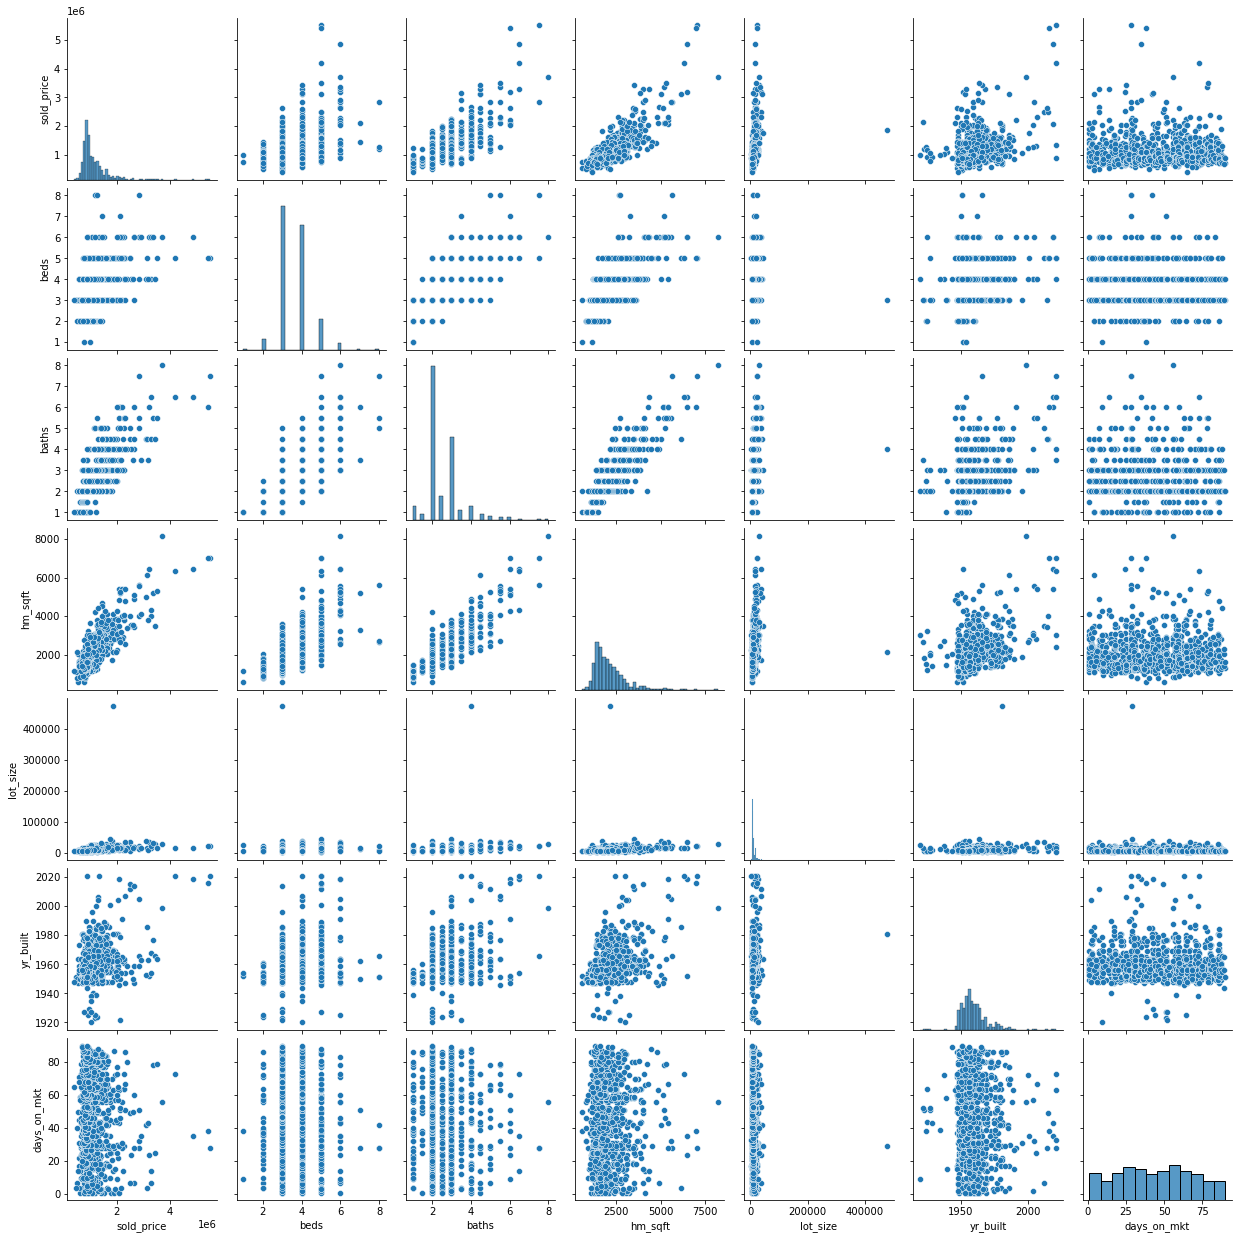

In [170]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']);

#### Drop that one home with a huge lot_size from the dataset (obvious undesirable outlier, not representative of vast majority)

In [171]:
print(df.shape)
df = df[df['lot_size'] < 200000]
df.reset_index(drop=True, inplace=True)
print(df.shape)

(1011, 18)
(1010, 18)


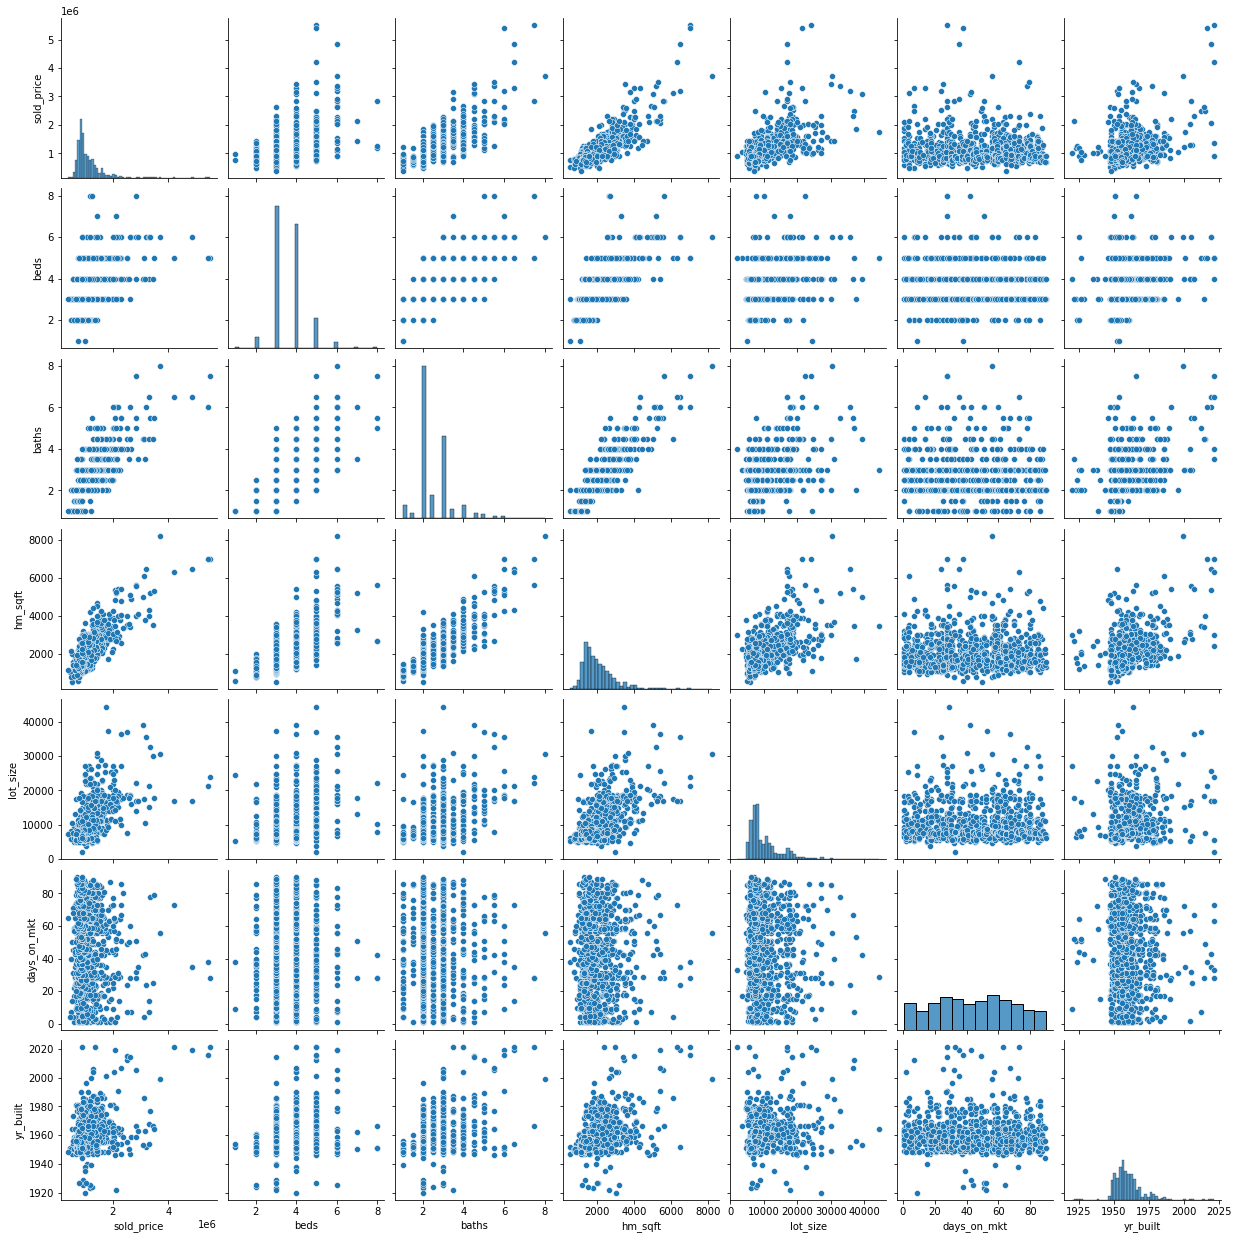

In [172]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'days_on_mkt', 'yr_built']);

In [173]:
df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 'days_on_mkt']].corr()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,days_on_mkt
sold_price,1.000000,0.468586,0.747992,0.836873,0.616309,0.405557,-0.015035
beds,0.468586,1.000000,0.677780,0.673701,0.353676,0.330157,-0.003969
baths,0.747992,0.677780,1.000000,0.853740,0.506800,0.425517,-0.003983
hm_sqft,0.836873,0.673701,0.853740,1.000000,0.611860,0.482993,-0.012386
lot_size,0.616309,0.353676,0.506800,0.611860,1.000000,0.235796,-0.011387
yr_built,0.405557,0.330157,0.425517,0.482993,0.235796,1.000000,-0.031676
days_on_mkt,-0.015035,-0.003969,-0.003983,-0.012386,-0.011387,-0.031676,1.000000


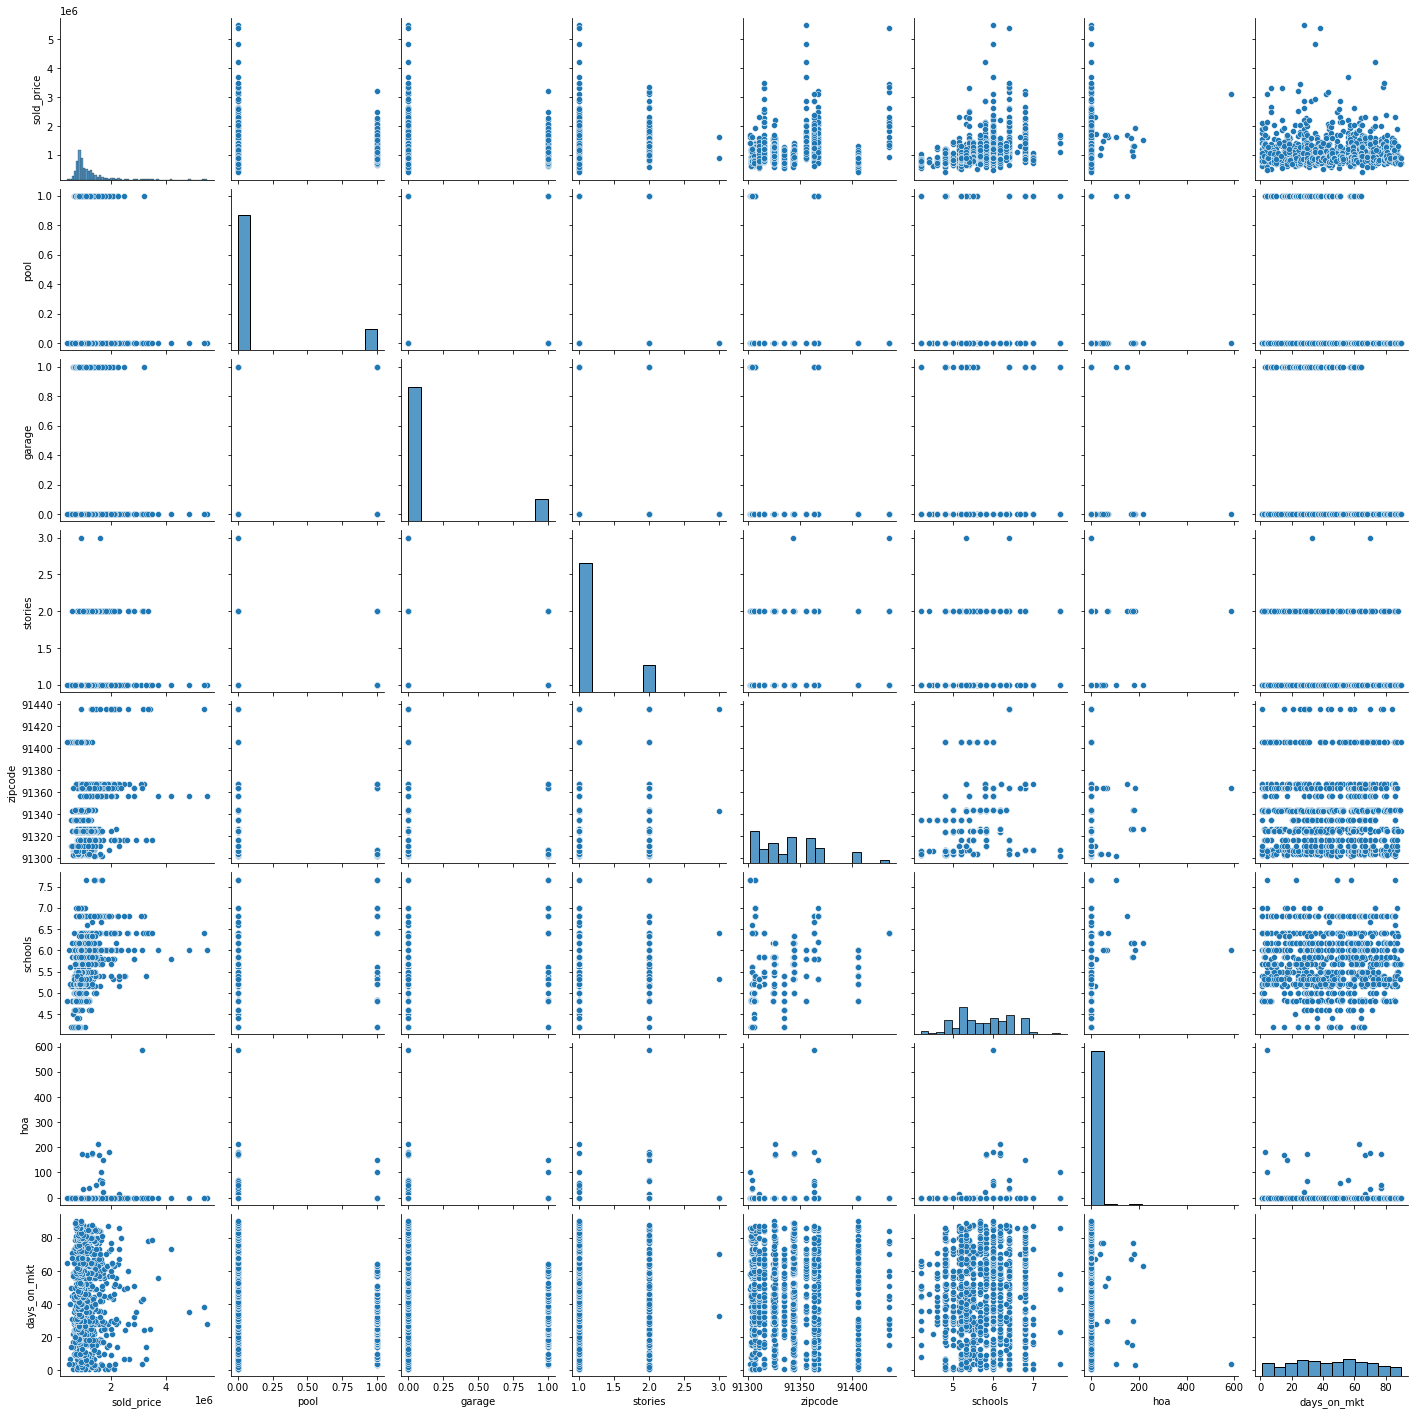

In [174]:
sns.pairplot(data = df, 
             vars = ['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']);

In [175]:
df[['sold_price', 'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa', 'days_on_mkt']].corr()

,sold_price,pool,garage,stories,zipcode,schools,hoa,days_on_mkt
sold_price,1.000000,0.028298,0.025144,0.187080,0.219329,0.356463,0.143552,-0.015035
pool,0.028298,1.000000,0.950247,0.074175,-0.100235,0.268048,-0.009247,-0.219170
garage,0.025144,0.950247,1.000000,0.057655,-0.096038,0.280840,-0.010762,-0.225222
stories,0.187080,0.074175,0.057655,1.000000,-0.028739,0.177494,0.136809,-0.051873
zipcode,0.219329,-0.100235,-0.096038,-0.028739,1.000000,0.267983,0.006319,-0.012574
schools,0.356463,0.268048,0.280840,0.177494,0.267983,1.000000,0.061756,-0.026134
hoa,0.143552,-0.009247,-0.010762,0.136809,0.006319,0.061756,1.000000,-0.042238
days_on_mkt,-0.015035,-0.219170,-0.225222,-0.051873,-0.012574,-0.026134,-0.042238,1.000000


#### Early conclusion: days_on_mkt (and alternative target) is uniformly distributed & pretty much uncorrelated w/ everything else!

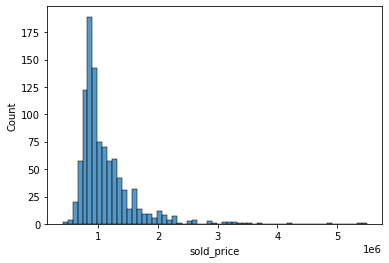

In [176]:
sns.histplot(data=df['sold_price']);

#### Perhaps log transforming the target can lead to a better model

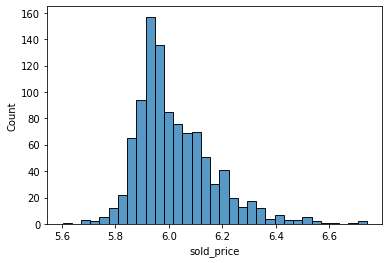

In [177]:
sns.histplot(data=np.log10(df['sold_price']));

# 2) Feature Engineering (part 1)

### Given the high VIFs with 1-hot zips, let's try grouping zipcodes into 'cities' and 1-hot that instead

In [178]:
df_data = df[['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built', 
              'pool', 'garage', 'stories', 'zipcode', 'schools', 'hoa']]

In [179]:
df_data['zipcode'].dtype

dtype('int64')

In [180]:
df_data['city'] = df_data['zipcode'].map({91302: 'woodland_hills',
                                          91303: 'canoga_park',
                                          91304: 'canoga_park',
                                          91306: 'winnetka',
                                          91307: 'west_hills',
                                          91311: 'chatsworth',
                                          91316: 'encino',
                                          91324: 'northridge',
                                          91325: 'northridge',
                                          91326: 'porter_ranch',
                                          91335: 'reseda',
                                          91343: 'north_hills',
                                          91344: 'granada_hills',
                                          91356: 'tarzana',
                                          91364: 'woodland_hills',
                                          91367: 'woodland_hills',
                                          91406: 'lake_balboa',
                                          91436: 'encino'}
                                        )

/var/folders/16/my2sdbrn4hvfl3_91fx0wj9c0000gn/T/ipykernel_46570/3655593410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['city'] = df_data['zipcode'].map({91302: 'woodland_hills',


In [181]:
df_data.drop(columns='zipcode')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sold_price  1010 non-null   int64  
 1   beds        1010 non-null   int64  
 2   baths       1010 non-null   float64
 3   hm_sqft     1010 non-null   int64  
 4   lot_size    1010 non-null   int64  
 5   yr_built    1010 non-null   int64  
 6   pool        1010 non-null   int64  
 7   garage      1010 non-null   int64  
 8   stories     1010 non-null   int64  
 9   zipcode     1010 non-null   int64  
 10  schools     1010 non-null   float64
 11  hoa         1010 non-null   int64  
 12  city        1010 non-null   object 
dtypes: float64(2), int64(10), object(1)
memory usage: 102.7+ KB


In [182]:
df_data = pd.get_dummies(df_data, columns=['city'], drop_first=True)
df_data.drop(columns='zipcode', inplace=True)

### Change 'stories' to binary variable 'one_story' (1 = yes, 0 = no => multi-story)

In [183]:
df_data['stories'].value_counts()

1    833
2    175
3      2
Name: stories, dtype: int64

In [184]:
df_data.loc[df_data['stories'] > 1, 'stories'] = 0
df_data.rename(columns={'stories': 'one_story'}, inplace=True)
df_data.head()

,sold_price,beds,baths,hm_sqft,lot_size,yr_built,pool,garage,one_story,schools,hoa,city_chatsworth,city_encino,city_granada_hills,city_lake_balboa,city_north_hills,city_northridge,city_porter_ranch,city_reseda,city_tarzana,city_west_hills,city_winnetka,city_woodland_hills
0,970000,4,3.0,1933,6999,1960,1,1,1,6.4,0,0,0,0,0,0,0,0,0,0,0,0,1
1,900000,3,2.0,1519,11761,1974,1,1,1,6.4,0,0,0,0,0,0,0,0,0,0,0,0,0
2,830000,3,2.0,1595,10560,1960,1,1,1,4.8,0,0,0,0,0,0,0,0,0,0,0,0,0
3,820000,3,2.5,1364,7253,1959,0,0,1,7.0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,940553,4,2.5,2018,9347,1960,1,1,1,6.8,0,0,0,0,0,0,0,0,0,0,0,0,1


In [185]:
df_data['one_story'].value_counts()

1    833
0    177
Name: one_story, dtype: int64

# 3) Baseline Features for Modeling

#### Define a Diagnostic Plot Function 
##### (adapted from func of same name provided in Metis linear assumptions & testing notebook)

In [186]:
def diagnostic_plots(x, y, y_pred):    
    
#     print('RMSE: {}'.format(round(mean_squared_error(y, y_pred, squared=False), 3)))
#     print('MAE: {}'.format(round(mean_absolute_error(y, y_pred), 3)))
    
    plt.figure(figsize=(20,5))
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred,y)
    plt.plot([5.6, 6.54], [5.6, 6.54], color='r', linestyle='-')
    plt.title("Predicted vs. Actual Sale Price")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [187]:
def cv_rsquareds(x, y, model, cv):    
    scores = cross_val_score(model, x, y, scoring='r2', cv=cv)
    scores = [round(val, 3) for val in scores]
    
    print('CV R-squareds: {}'.format(scores)) 
    print('Mean CV R-squared: {} +/- {}'.format(round(np.mean(scores), 3), round(np.std(scores), 3)))
    
    n = x.shape[0]
    p = x.shape[1]
    adj_r_squareds = [round(1 - (1 - r_squared)*((n - 1)/(n - p - 1)), 3) for r_squared in scores]
    print('\nAdjusted CV R-squareds: {}'.format(adj_r_squareds))
    print('Mean Adjusted CV R-squared: {} +/- {}'.format(round(np.mean(adj_r_squareds), 3), 
                                                         round(np.std(adj_r_squareds), 3)))

In [188]:
# This function inverts the log transform on y_pred and y prior so that MAE can be computed in dollars

def mae_for_log_y(y, y_pred):
    return mean_absolute_error(10**y, 10**y_pred)

scorer = make_scorer(mae_for_log_y, greater_is_better=False)

In [189]:
def cv_maes(x, y, model, cv):
    scores = cross_val_score(model, x, y, scoring=scorer, cv=cv)
    scores = [round(val) for val in scores]
    
    print('\nCV MAEs: {}'.format([-1*score for score in scores])) 
    print('Mean CV MAE: {} +/- {}'.format(-1*round(np.mean(scores)), round(np.std(scores))))

### Split into CV and Test Sets (will NOT touch Test set until final model has been chosen and tuned!)

In [190]:
X = df_data.drop(columns='sold_price')
y = np.log10(df_data['sold_price'])

In [191]:
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Baseline Model 1: Linear Model, all features

In [192]:
model_1 = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1, 5)
cv_maes(X_cv, y_cv, model_1, 5)

CV R-squareds: [0.822, 0.832, 0.836, 0.854, 0.842]
Mean CV R-squared: 0.837 +/- 0.011

Adjusted CV R-squareds: [0.817, 0.827, 0.831, 0.85, 0.838]
Mean Adjusted CV R-squared: 0.833 +/- 0.011

CV MAEs: [155512, 118132, 116949, 121273, 114859]
Mean CV MAE: 125345 +/- 15226


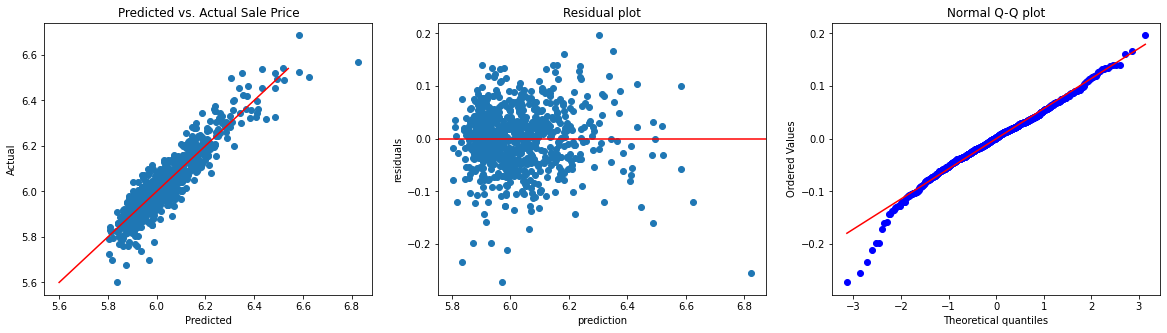

In [193]:
model_1.fit(X_cv, y_cv)

y_pred = model_1.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

#### Are the two highest priced predictions  influential points? Let's refit this using statsmodels to find out:

In [102]:
x_cv = sm.add_constant(X_cv)
model = sm.OLS(y_cv, x_cv)
model_1b = model.fit()
model_1b.summary()

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sold_price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     198.3
Date:                Mon, 06 Sep 2021   Prob (F-statistic):          1.49e-302
Time:                        23:28:34   Log-Likelihood:                 1161.0
No. Observations:                 808   AIC:                            -2276.
Df Residuals:                     785   BIC:                            -2168.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.1318      0.435     11.809      0.000       4.279       5.985
beds                   -0.0024      0.004     -0.640      0.522      -0.010       0.005
baths                   0.0239      0.005      5.277      0.000       0.015       0.033
hm_sqft              7.617e-05    5.4e-06     14.099      0.000    6.56e-05    8.68e-05
lot_size             5.671e-06    5.3e-07     10.707      0.000    4.63e-06    6.71e-06
yr_built                0.0002      0.000      0.889      0.374      -0.000       0.001
pool                   -0.0045      0.020     -0.222      0.825      -0.044       0.035
garage                  0.0006      0.020      0.032      0.975      -0.039       0.040
one_story               0.0149      0.006      2.387      0.017       0.003       0.027
schools                 0.0364      0.005      7.537      0.000       0.027       0.046
hoa                  8.908e-05   7.79e-05      1.143      0.253   -6.39e-05       0.000
city_chatsworth        -0.0451      0.013     -3.492      0.001      -0.070      -0.020
city_encino             0.1261      0.012     10.783      0.000       0.103       0.149
city_granada_hills     -0.0249      0.010     -2.462      0.014      -0.045      -0.005
city_lake_balboa       -0.0176      0.011     -1.641      0.101      -0.039       0.003
city_north_hills       -0.0386      0.011     -3.378      0.001      -0.061      -0.016
city_northridge        -0.0137      0.011     -1.238      0.216      -0.036       0.008
city_porter_ranch      -0.0019      0.012     -0.158      0.875      -0.026       0.022
city_reseda             0.0004      0.011      0.038      0.969      -0.022       0.023
city_tarzana            0.0877      0.013      6.592      0.000       0.062       0.114
city_west_hills        -0.0240      0.012     -2.063      0.039      -0.047      -0.001
city_winnetka          -0.0230      0.013     -1.710      0.088      -0.049       0.003
city_woodland_hills     0.0378      0.010      3.688      0.000       0.018       0.058
==============================================================================
Omnibus:                       55.160   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.868
Skew:                          -0.428   Prob(JB):                     3.10e-25
Kurtosis:                       4.619   Cond. No.                     2.54e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [103]:
influence_frame = model_1b.get_influence().summary_frame()
influence_frame['cooks_d'].sort_values(ascending=False).head()

499    0.123343
743    0.020294
129    0.019623
587    0.018494
695    0.017898
Name: cooks_d, dtype: float64

##### Technically, no influence points (Cook's dist > 0.5), but as suspected, largest Cook's distances are all for sale prices > 3e6

In [104]:
print(y_cv.loc[499])
print(y_cv.loc[743])
print(y_cv.loc[129])
print(y_cv.loc[587])

6.569373909615046
5.69810054562339
6.317018101048111
5.7363965022766426


In [105]:
df_data[df_data['sold_price'] >= 3e6].shape[0]

14

In [106]:
df_data['sold_price'].describe()

count    1.010000e+03
mean     1.125490e+06
std      5.020166e+05
min      4.000000e+05
25%      8.400000e+05
50%      9.650000e+05
75%      1.260000e+06
max      5.500000e+06
Name: sold_price, dtype: float64

In [107]:
df_data[df_data['sold_price'] <= 3e6]['sold_price'].describe()

count    9.960000e+02
mean     1.087947e+06
std      3.799263e+05
min      4.000000e+05
25%      8.387500e+05
50%      9.600000e+05
75%      1.250000e+06
max      2.919500e+06
Name: sold_price, dtype: float64

#### While we're here, what about colinearity (VIF)?

In [108]:
variables = model_1b.model.exog

# Don't count the intercept! (index=0)
vifs = [variance_inflation_factor(variables, i) for i in range(1, variables.shape[1])]
list(zip(X_cv.columns, vifs))

[('beds', 2.3148128749207326),
 ('baths', 4.043471517332343),
 ('hm_sqft', 5.388832661032012),
 ('lot_size', 1.804812618293314),
 ('yr_built', 1.5541937438842295),
 ('pool', 11.55709054017307),
 ('garage', 11.693702898655935),
 ('one_story', 1.343850740615704),
 ('schools', 2.510301883327543),
 ('hoa', 1.0934388039308098),
 ('city_chatsworth', 1.4612584697994708),
 ('city_encino', 2.1620786184485126),
 ('city_granada_hills', 2.3727980763444694),
 ('city_lake_balboa', 1.9428917929050251),
 ('city_north_hills', 1.7670036533211684),
 ('city_northridge', 1.8548367675667148),
 ('city_porter_ranch', 2.009986217982023),
 ('city_reseda', 1.692616002511555),
 ('city_tarzana', 1.645057586080708),
 ('city_west_hills', 1.9691722555592364),
 ('city_winnetka', 1.3905932150645586),
 ('city_woodland_hills', 4.226194025443885)]

#### Note that the previous VIFs for the 'zipcode' 1-hots were way worse than these for the 'city' 1-hots!

In [109]:
df_data[['pool', 'garage']].corr()

,pool,garage
pool,1.000000,0.950247
garage,0.950247,1.000000


In [110]:
df_data[['pool', 'garage']].value_counts()

pool  garage
0     0         865
1     1         133
0     1           9
1     0           3
dtype: int64

#### Aha! 'pool' & 'garage' are highly correlated (missed that in the pair plots); let's drop 'pool'

In [111]:
df_data = df_data.drop(columns='pool')

In [113]:
df_data.columns

Index(['sold_price', 'beds', 'baths', 'hm_sqft', 'lot_size', 'yr_built',
       'garage', 'one_story', 'schools', 'hoa', 'city_chatsworth',
       'city_encino', 'city_granada_hills', 'city_lake_balboa',
       'city_north_hills', 'city_northridge', 'city_porter_ranch',
       'city_reseda', 'city_tarzana', 'city_west_hills', 'city_winnetka',
       'city_woodland_hills'],
      dtype='object')

##### Command decision: 'sold_price' >= 3 million is almost 4-sigma from the mean, so let's just drop the 14 >= 3 million dollar homes
##### (i.e. This model is geared towards the much more common lower home prices, not the handful of very high-priced homes)

In [194]:
X = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
y = np.log10(df_data[df_data['sold_price'] <= 3e6]['sold_price'])

X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [195]:
model_1c = LinearRegression()

cv_rsquareds(X_cv, y_cv, model_1c, 5)
cv_maes(X_cv, y_cv, model_1c, 5)

CV R-squareds: [0.867, 0.814, 0.792, 0.788, 0.744]
Mean CV R-squared: 0.801 +/- 0.04

Adjusted CV R-squareds: [0.863, 0.809, 0.786, 0.782, 0.737]
Mean Adjusted CV R-squared: 0.795 +/- 0.041

CV MAEs: [126620, 115673, 114513, 104741, 120437]
Mean CV MAE: 116397 +/- 7222


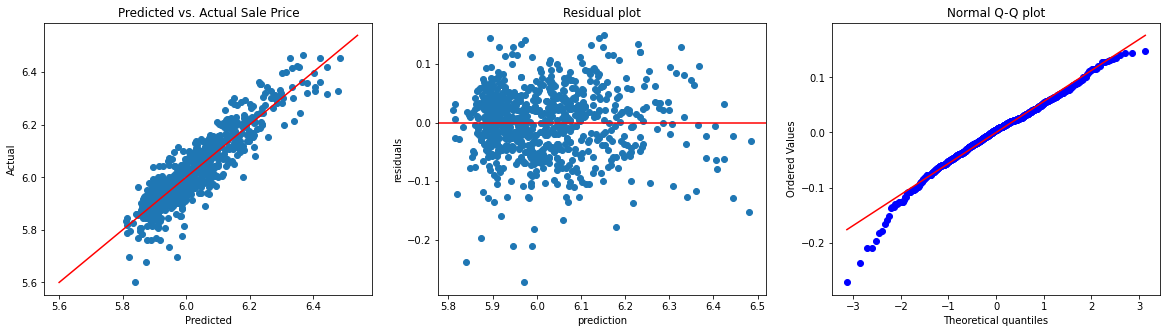

In [196]:
model_1c.fit(X_cv, y_cv)

y_pred = model_1c.predict(X_cv)

diagnostic_plots(X_cv, y_cv, y_pred)

### Model 2: Try adding some further features

#### 'beds', 'baths', 'hm_sqft', 'schools' all show signs of a possible 2nd-order relationship w/ 'sold_price'

In [197]:
df_data['beds_SQ'] = df_data['beds'] * df_data['beds']
df_data['baths_SQ'] = df_data['baths'] * df_data['baths']
df_data['hm_sqft_SQ'] = df_data['hm_sqft'] * df_data['hm_sqft']
df_data['lot_size_SQ'] = df_data['lot_size'] * df_data['lot_size']
df_data['schools_SQ'] = df_data['schools'] * df_data['schools']
df_data['yr_built_SQ'] = df_data['yr_built'] * df_data['yr_built']

In [198]:
X2 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X2_cv, X2_test, y2_cv, y2_test = train_test_split(X2, y, test_size=0.2, random_state=42)

In [199]:
model_2 = LinearRegression()

cv_rsquareds(X2_cv, y2_cv, model_2, 5)
cv_maes(X2_cv, y2_cv, model_2, 5)

CV R-squareds: [0.875, 0.826, 0.796, 0.795, 0.748]
Mean CV R-squared: 0.808 +/- 0.042

Adjusted CV R-squareds: [0.87, 0.82, 0.789, 0.788, 0.739]
Mean Adjusted CV R-squared: 0.801 +/- 0.043

CV MAEs: [120389, 110831, 110049, 99644, 116954]
Mean CV MAE: 111573 +/- 7097


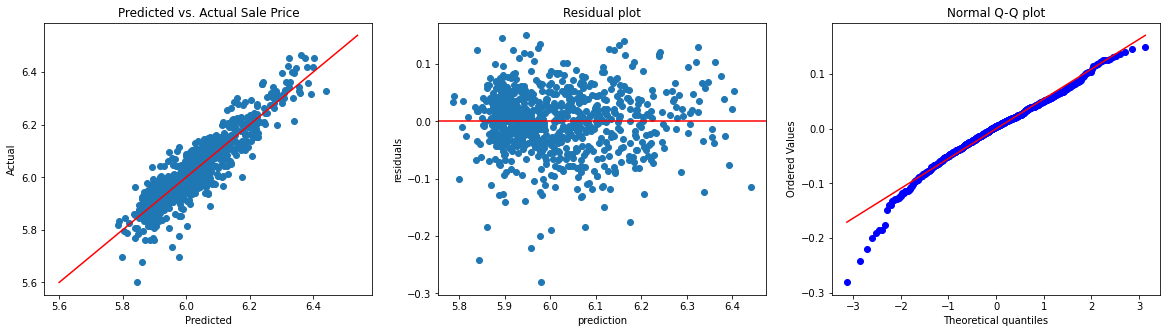

In [200]:
model_2.fit(X2_cv, y2_cv)

y2_pred = model_2.predict(X2_cv)

diagnostic_plots(X2_cv, y2_cv, y2_pred)

In [121]:
list(zip(X2_cv.columns, model_2.coef_))

[('beds', 0.013061468889818042),
 ('baths', 0.02339952235959319),
 ('hm_sqft', 0.00011005861862942089),
 ('lot_size', 1.2229426718724154e-05),
 ('yr_built', 0.0031024580800118324),
 ('garage', -0.0008042452255014157),
 ('one_story', 0.012610080477931444),
 ('schools', -0.07032708745948937),
 ('hoa', 0.00010296253107384757),
 ('city_chatsworth', -0.027081480496213617),
 ('city_encino', 0.13827950002155634),
 ('city_granada_hills', -0.013810442834978197),
 ('city_lake_balboa', 0.00012457503458050386),
 ('city_north_hills', -0.03304879003524139),
 ('city_northridge', -0.005773217247446905),
 ('city_porter_ranch', 0.005669667909653976),
 ('city_reseda', 0.014923179165842421),
 ('city_tarzana', 0.08649238280538087),
 ('city_west_hills', -0.018357572929872147),
 ('city_winnetka', -0.02393868265483935),
 ('city_woodland_hills', 0.049308657986213165),
 ('beds_SQ', -0.002051140798317549),
 ('baths_SQ', 0.00033968653975977823),
 ('hm_sqft_SQ', -7.073243731177403e-09),
 ('lot_size_SQ', -1.9775801

### Model 3: Try "Lazy" Lasso (specifically to eliminate some predictors)

In [201]:
X3 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X3_cv, X3_test, y3_cv, y3_test = train_test_split(X3, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X3_cv_scaled = scaler.fit_transform(X3_cv)

In [124]:
alphas = 10**np.linspace(-4, 4, 1000)
lasso_model = LassoCV(alphas=alphas, cv=5, normalize=False, max_iter=100000)

lasso_model.fit(X3_cv_scaled, y3_cv)

alpha = round(lasso_model.alpha_, 4)
print('Best alpha: {}'.format(alpha))

Best alpha: 0.0001


In [202]:
model_3 = Lasso(alpha=0.0001, max_iter=100000)

cv_rsquareds(X3_cv_scaled, y3_cv, model_3, 5)
cv_maes(X3_cv_scaled, y3_cv, model_3, 5)

CV R-squareds: [0.876, 0.825, 0.797, 0.794, 0.755]
Mean CV R-squared: 0.809 +/- 0.04

Adjusted CV R-squareds: [0.871, 0.819, 0.79, 0.786, 0.746]
Mean Adjusted CV R-squared: 0.802 +/- 0.041

CV MAEs: [120051, 111334, 110931, 100148, 116238]
Mean CV MAE: 111740 +/- 6701


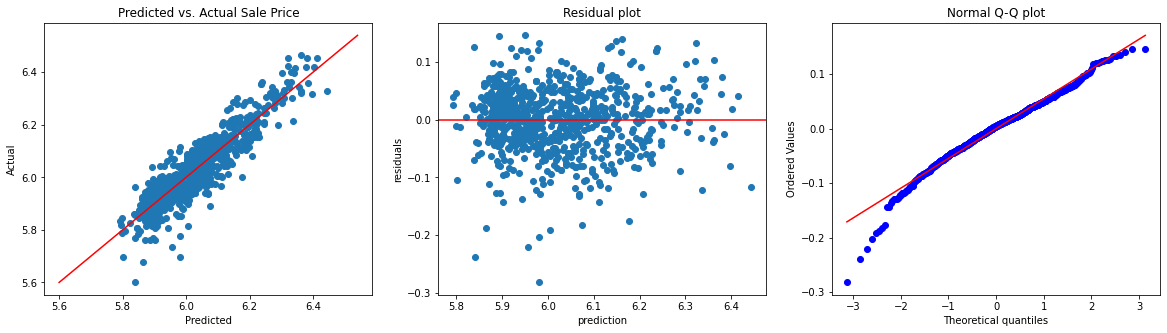

In [203]:
model_3.fit(X3_cv_scaled, y3_cv)

y3_pred = model_3.predict(X3_cv_scaled)

diagnostic_plots(X3_cv, y3_cv, y3_pred)

#### On a Mean MAE basis, this is on par w/ Model 2 (even slightly better)

In [127]:
list(zip(X3_cv.columns, model_3.coef_))

[('beds', 0.005751680335984271),
 ('baths', 0.021190455119225297),
 ('hm_sqft', 0.08468892708666885),
 ('lot_size', 0.059619872900953844),
 ('yr_built', 0.0022525177533323816),
 ('garage', 3.807929762458984e-05),
 ('one_story', 0.004568321962107655),
 ('schools', -0.0),
 ('hoa', 0.0017590415709657248),
 ('city_chatsworth', -0.005214880415864678),
 ('city_encino', 0.03465644347598576),
 ('city_granada_hills', -0.0051449161611832415),
 ('city_lake_balboa', -0.0007697517604371806),
 ('city_north_hills', -0.008403009225261895),
 ('city_northridge', -0.002044647623297955),
 ('city_porter_ranch', 0.0005347333408903484),
 ('city_reseda', 0.0033882148918366554),
 ('city_tarzana', 0.01639143801657858),
 ('city_west_hills', -0.0045707610674594),
 ('city_winnetka', -0.0041794173386252385),
 ('city_woodland_hills', 0.019488851897661176),
 ('beds_SQ', -0.008700863560206098),
 ('baths_SQ', -0.0),
 ('hm_sqft_SQ', -0.027778260353087312),
 ('lot_size_SQ', -0.030552103457068026),
 ('schools_SQ', 0.01856

#### Only a few got driven to zero; can't drop schools since schools_SQ is non-zero; hardly seems worth dropping baths_SQ

### Model 4 - "Lazy" Ridge Regression

In [204]:
X4 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X4_cv, X4_test, y4_cv, y4_test = train_test_split(X4, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X4_cv_scaled = scaler.fit_transform(X4_cv)

In [130]:
alphas = np.linspace(0.0001, 10000, 1000)
ridge_model = RidgeCV(alphas=alphas, cv=5, normalize=False)

ridge_model.fit(X4_cv_scaled, y4_cv)

alpha = round(ridge_model.alpha_, 4)
print('Best alpha: {}'.format(alpha))

Best alpha: 0.0001


In [205]:
model_4 = Ridge(alpha=0.0001, max_iter=100000)

cv_rsquareds(X4_cv_scaled, y4_cv, model_4, 5)
cv_maes(X4_cv_scaled, y4_cv, model_4, 5)

CV R-squareds: [0.875, 0.826, 0.796, 0.795, 0.748]
Mean CV R-squared: 0.808 +/- 0.042

Adjusted CV R-squareds: [0.87, 0.82, 0.789, 0.788, 0.739]
Mean Adjusted CV R-squared: 0.801 +/- 0.043

CV MAEs: [120383, 110831, 110048, 99644, 116951]
Mean CV MAE: 111571 +/- 7095


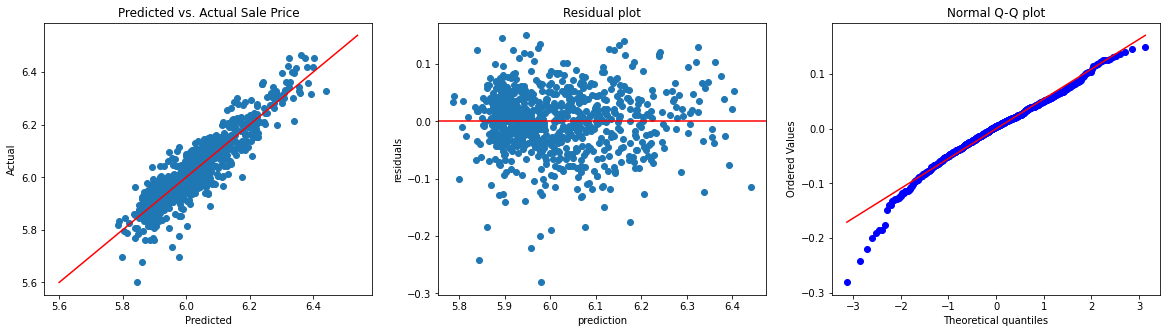

In [206]:
model_4.fit(X4_cv_scaled, y4_cv)

y4_pred = model_4.predict(X4_cv_scaled)

diagnostic_plots(X4_cv_scaled, y4_cv, y4_pred)

#### On a Mean MAE basis, this is on par w/ Model 2

### Model 5 - "Lazy" ElasticNet Regression (all the variables in the model)

In [207]:
X5 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')

X5_cv, X5_test, y5_cv, y5_test = train_test_split(X5, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X5_cv_scaled = scaler.fit_transform(X5_cv)

In [134]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l1_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1]

elastic_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=1500000)

elastic_model.fit(X5_cv_scaled, y5_cv)

alpha = round(elastic_model.alpha_, 4)
print('Best alpha = {}'.format(alpha))
l1_ratio = round(elastic_model.l1_ratio_, 2)
print('Best L1 Ratio = {}'.format(l1_ratio))

Best alpha = 0.001
Best L1 Ratio = 0.1


In [208]:
model_5 = ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=1500000)

cv_rsquareds(X5_cv_scaled, y5_cv, model_5, 5)
cv_maes(X5_cv_scaled, y5_cv, model_5, 5)

CV R-squareds: [0.876, 0.825, 0.797, 0.794, 0.755]
Mean CV R-squared: 0.809 +/- 0.04

Adjusted CV R-squareds: [0.871, 0.819, 0.79, 0.786, 0.746]
Mean Adjusted CV R-squared: 0.802 +/- 0.041

CV MAEs: [120028, 111375, 110882, 100275, 116256]
Mean CV MAE: 111763 +/- 6654


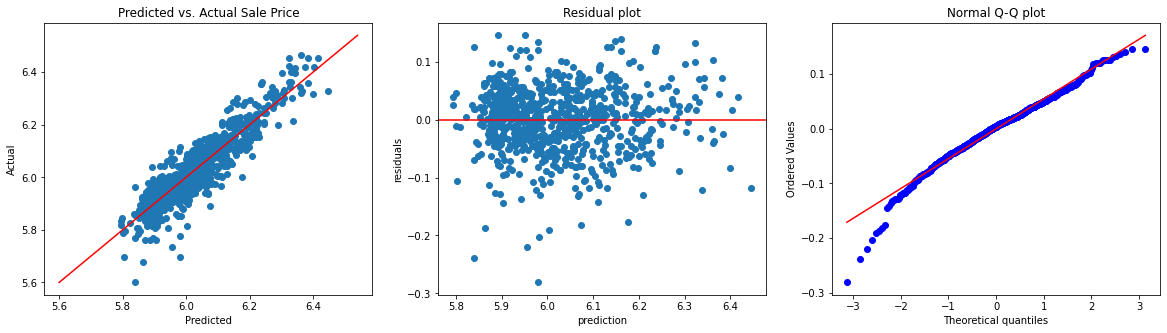

In [209]:
model_5.fit(X5_cv_scaled, y5_cv)

y5_pred = model_5.predict(X5_cv_scaled)

diagnostic_plots(X5_cv_scaled, y5_cv, y5_pred)

#### This looks like the best yet (on a Mean CV MAE basis)

In [137]:
list(zip(X5_cv.columns, model_5.coef_))

[('beds', 0.0063126805305703405),
 ('baths', 0.021571953558245024),
 ('hm_sqft', 0.08243829528921595),
 ('lot_size', 0.05893563198421888),
 ('yr_built', 0.0020665837705108048),
 ('garage', 2.2206606237327158e-05),
 ('one_story', 0.004500712656179676),
 ('schools', -0.0),
 ('hoa', 0.0017657790928545941),
 ('city_chatsworth', -0.005215763887914108),
 ('city_encino', 0.03457230485891655),
 ('city_granada_hills', -0.005219321259833),
 ('city_lake_balboa', -0.0008974024615871302),
 ('city_north_hills', -0.008453195468193236),
 ('city_northridge', -0.0020460685703897986),
 ('city_porter_ranch', 0.000530337980021119),
 ('city_reseda', 0.0032881131605667037),
 ('city_tarzana', 0.016396514019907306),
 ('city_west_hills', -0.004642366122216674),
 ('city_winnetka', -0.004225744524857589),
 ('city_woodland_hills', 0.019376803014896526),
 ('beds_SQ', -0.009148207769383616),
 ('baths_SQ', -0.00026691497036029915),
 ('hm_sqft_SQ', -0.02574276820058232),
 ('lot_size_SQ', -0.02986668090850398),
 ('scho

In [138]:
var_magnitudes = sorted(list(zip(X5_cv.columns, model_5.coef_)), key=lambda x: x[1])

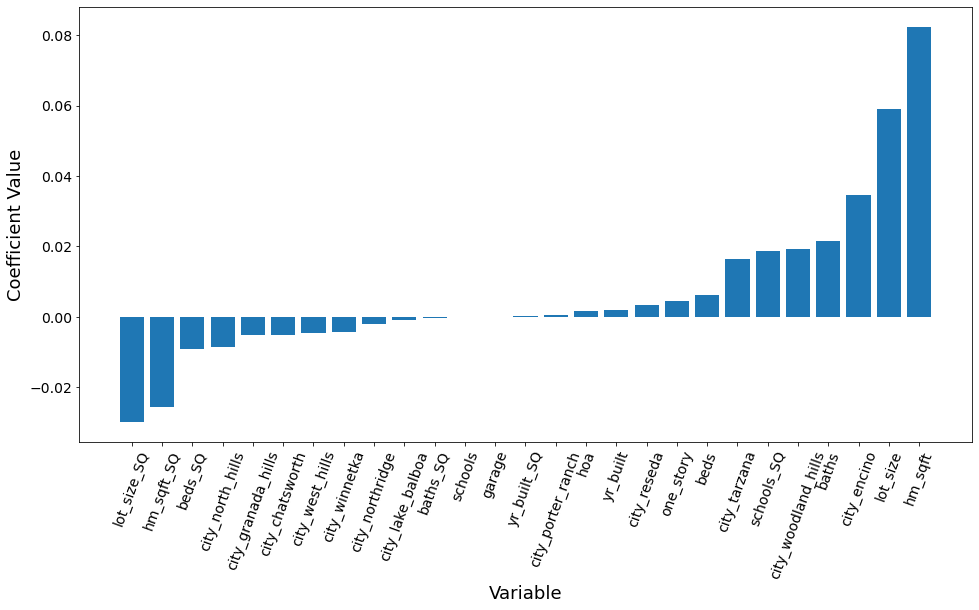

In [139]:
plt.figure(figsize=(16,8))
plt.bar(range(len(var_magnitudes)), [val[1] for val in var_magnitudes], align='center')
plt.xticks(range(len(var_magnitudes)), [val[0] for val in var_magnitudes])
plt.xticks(rotation=70, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Variable', fontsize=18)
plt.ylabel('Coefficient Value', fontsize=18)
plt.show()

In [140]:
X5_cv_scaled[0]

array([ 0.46039717,  0.58051815,  0.33392887, -0.27152612,  1.45515338,
       -0.41093711, -2.19322114,  0.65198815, -0.11014995, -0.19094065,
       -0.27772515, -0.35029707, -0.28293864, -0.24765567, -0.26977079,
        3.82202082, -0.23896634, -0.2046578 , -0.27772515, -0.2112331 ,
       -0.52306787,  0.32065466,  0.36528381,  0.12263283, -0.31495982,
        0.61548229,  1.452118  ])

In [141]:
coeffs = [val[1] for val in list(zip(X5_cv.columns, model_5.coef_))]
pred = []
for n in range(len(X5_cv_scaled[0])):
    pred.append(X5_cv_scaled[0][n] * coeffs[n])
np.sum(pred) + model_5.intercept_

6.037210668384832

### Model 6: Random Forest Regression

In [210]:
X6 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
X6_cv, X6_test, y6_cv, y6_test = train_test_split(X6, y, test_size=0.2, random_state=42)

In [143]:
grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]}

model_rf = RandomForestRegressor()

rf_gridsearch = RandomizedSearchCV(estimator = model_rf, 
                                   param_distributions = grid, 
                                   n_iter = 500, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

rf_gridsearch.fit(X6_cv, y6_cv)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='r2')

In [144]:
rf_gridsearch.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': False}

In [145]:
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {'n_estimators': [500, 550, 600, 650, 700],
        'max_features': ['log2'],
        'max_depth': [5, 10, 15],
        'min_samples_split': [3, 4, 5, 6, 7],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [False]}

# Perform grid search
grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X6_cv, y6_cv)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [5, 10, 15],
                         'max_features': ['log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'n_estimators': [500, 550, 600, 650, 700]})

In [146]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 500}

In [211]:
model_6 = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=10,
    bootstrap=False
)

cv_rsquareds(X6_cv, y6_cv, model_6, 5)
cv_maes(X6_cv, y6_cv, model_6, 5)

CV R-squareds: [0.849, 0.804, 0.752, 0.725, 0.762]
Mean CV R-squared: 0.778 +/- 0.043

Adjusted CV R-squareds: [0.843, 0.797, 0.743, 0.715, 0.753]
Mean Adjusted CV R-squared: 0.77 +/- 0.045

CV MAEs: [126853, 114995, 124486, 117926, 111928]
Mean CV MAE: 119238 +/- 5634


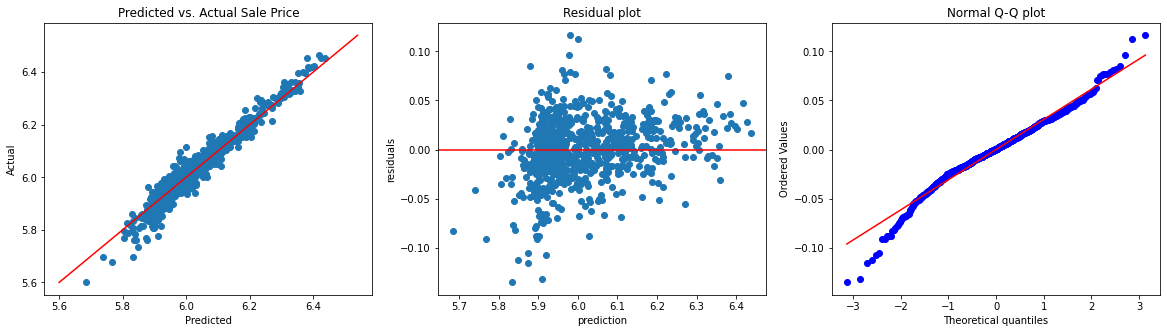

In [212]:
model_6.fit(X6_cv, y6_cv)

y6_pred = model_6.predict(X6_cv)

diagnostic_plots(X6_cv, y6_cv, y6_pred)

In [149]:
feature_importances = sorted(list(zip(X6_cv.columns, model_6.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances

[('hm_sqft_SQ', 0.17884328139759192),
 ('hm_sqft', 0.17209252519564133),
 ('lot_size', 0.1150495691584735),
 ('lot_size_SQ', 0.1105914184423968),
 ('baths', 0.08823551203239727),
 ('baths_SQ', 0.0783769631053182),
 ('schools', 0.0456119527612449),
 ('schools_SQ', 0.04556736205585336),
 ('city_encino', 0.028713899511757752),
 ('city_woodland_hills', 0.023993116872771097),
 ('yr_built', 0.02158409654120701),
 ('yr_built_SQ', 0.01958940982116585),
 ('beds', 0.01861051020533564),
 ('beds_SQ', 0.017244974525291272),
 ('city_tarzana', 0.006704449481969504),
 ('one_story', 0.0049600551977390375),
 ('city_north_hills', 0.004401636300566425),
 ('city_lake_balboa', 0.0038054048988762877),
 ('city_granada_hills', 0.003072891772397238),
 ('city_northridge', 0.0024047127011181833),
 ('city_winnetka', 0.0023023679139254453),
 ('city_porter_ranch', 0.0016688816914359678),
 ('city_west_hills', 0.0016333725707395788),
 ('garage', 0.0013804050508515943),
 ('city_reseda', 0.0013044025337962323),
 ('city_

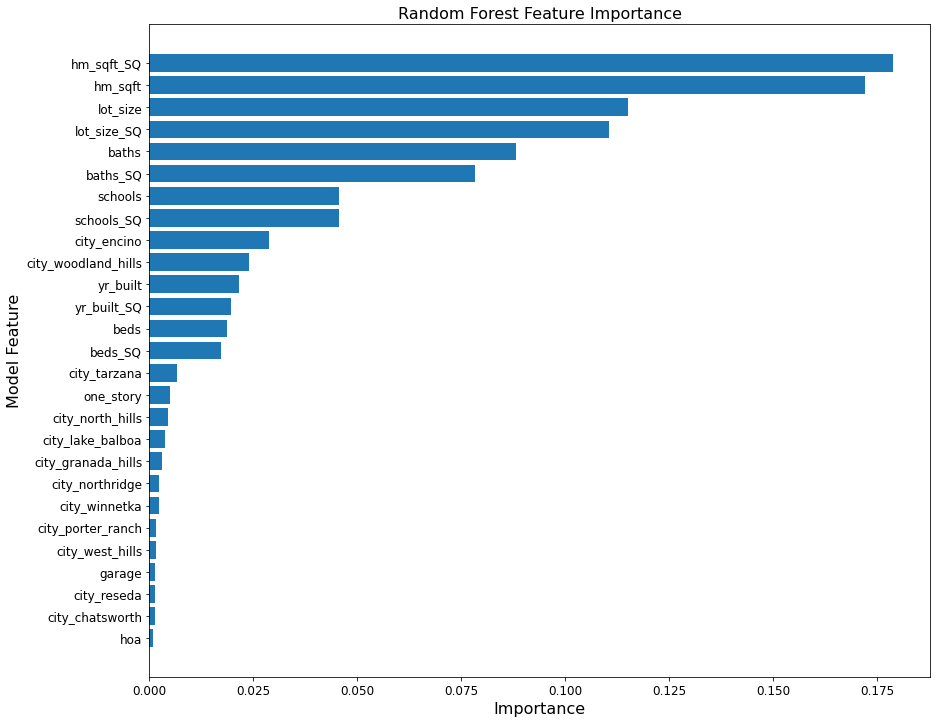

In [150]:
sorted_idx = model_6.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X6_cv.columns[sorted_idx], model_6.feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

### Model 7 - XGBoost

In [213]:
X7 = df_data[df_data['sold_price'] <= 3e6].drop(columns='sold_price')
X7_cv, X7_test, y7_cv, y7_test = train_test_split(X7, y, test_size=0.2, random_state=42)

In [152]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 2, 3, 5],
        'subsample': [0.3, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'n_estimators' : [100, 200, 500, 1000],
        'objective': ['reg:squarederror', 'reg:pseudohubererror']
}

model_xgb = xgboost.XGBRegressor()

xgb_gridsearch = RandomizedSearchCV(estimator = model_xgb, 
                                   param_distributions = grid, 
                                   n_iter = 200, 
                                   cv = 5, 
                                   scoring = 'r2',
                                   verbose=0, 
                                   random_state=42, 
                                   n_jobs = -1)

xgb_gridsearch.fit(X7_cv, y7_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
   

In [153]:
warnings.filterwarnings(action='ignore', category=UserWarning)
xgb_gridsearch.best_params_

{'subsample': 0.5,
 'objective': 'reg:pseudohubererror',
 'n_estimators': 1000,
 'min_child_weight': 2,
 'max_depth': 3,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

In [154]:
warnings.filterwarnings(action='ignore', category=UserWarning)
# Updated/narrowed-down grid based on the results found by randomized search above
grid = {
        'learning_rate': [0.001, 0.005, 0.01],
        'max_depth': [1, 2, 3, 4],
        'min_child_weight': [1, 2, 3],
        'subsample': [0.4, 0.5, 0.6],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'n_estimators' : [900, 1000, 1200],
        'objective': ['reg:pseudohubererror']
}

# Perform grid search
grid_search = GridSearchCV(estimator = xgboost.XGBRegressor(), param_grid = grid, 
                          cv = 5, n_jobs = -1, verbose = 0)

grid_search.fit(X7_cv, y7_cv)

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [155]:
warnings.filterwarnings(action='ignore', category=UserWarning)
grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 1000,
 'objective': 'reg:pseudohubererror',
 'subsample': 0.5}

In [214]:
# Need this to filter annoying warnings (known bug/'feature' of XGBoost)
warnings.filterwarnings(action='ignore', category=UserWarning)

# model_xgb = xgboost.XGBRegressor(objective='reg:pseudohubererror', random_state=42)
model_7 = xgboost.XGBRegressor(
        subsample=0.5,
        objective='reg:pseudohubererror',
        n_estimators=1000,
        min_child_weight=2,
        max_depth=4,
        learning_rate=0.01,
        colsample_bytree=0.7
)

cv_rsquareds(X7_cv, y7_cv, model_7, 5)
cv_maes(X7_cv, y7_cv, model_7, 5)

CV R-squareds: [0.869, 0.813, 0.791, 0.758, 0.769]
Mean CV R-squared: 0.8 +/- 0.039

Adjusted CV R-squareds: [0.864, 0.806, 0.783, 0.749, 0.761]
Mean Adjusted CV R-squared: 0.793 +/- 0.041

CV MAEs: [118767, 111961, 108520, 106284, 109006]
Mean CV MAE: 110908 +/- 4326


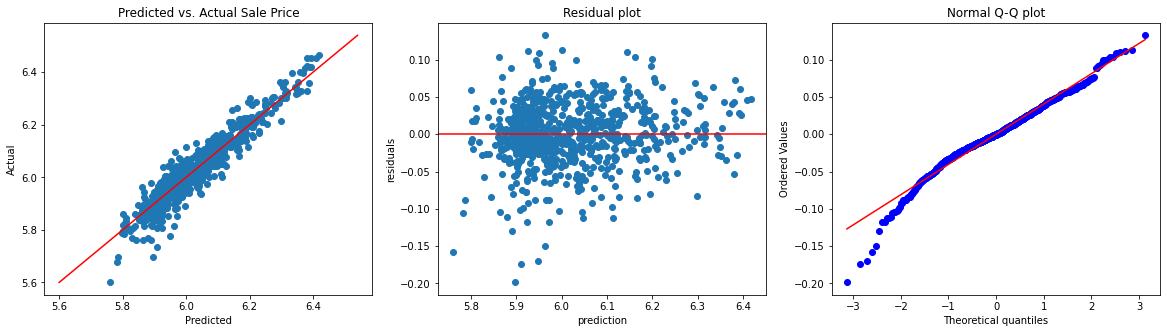

In [215]:
model_7.fit(X7_cv, y7_cv)

y7_pred = model_7.predict(X7_cv)

diagnostic_plots(X7_cv, y7_cv, y7_pred)

In [158]:
model_7.get_booster().get_score(importance_type="gain")

{'hm_sqft': 0.036787698327616386,
 'hm_sqft_SQ': 0.032406959884259824,
 'lot_size': 0.015992127411249557,
 'lot_size_SQ': 0.023223102479934442,
 'schools': 0.016197281618796012,
 'schools_SQ': 0.020339269496137503,
 'baths': 0.02727012950183548,
 'baths_SQ': 0.018816244989034482,
 'city_encino': 0.04538367142531897,
 'city_woodland_hills': 0.038011793127562345,
 'city_porter_ranch': 0.008053900047241377,
 'city_tarzana': 0.0219998162774074,
 'city_lake_balboa': 0.014084339764247623,
 'city_granada_hills': 0.012579074158428571,
 'beds': 0.00753822754616289,
 'city_north_hills': 0.012270396053052628,
 'yr_built': 0.007391898721785681,
 'one_story': 0.006376802407648911,
 'city_west_hills': 0.00941117501826923,
 'yr_built_SQ': 0.007307308893287375,
 'city_northridge': 0.008831890132272726,
 'city_winnetka': 0.009222398554838708,
 'city_chatsworth': 0.010291464710129868,
 'beds_SQ': 0.007059319011564708,
 'garage': 0.006559962017375,
 'city_reseda': 0.009109883201688315,
 'hoa': 0.00531378

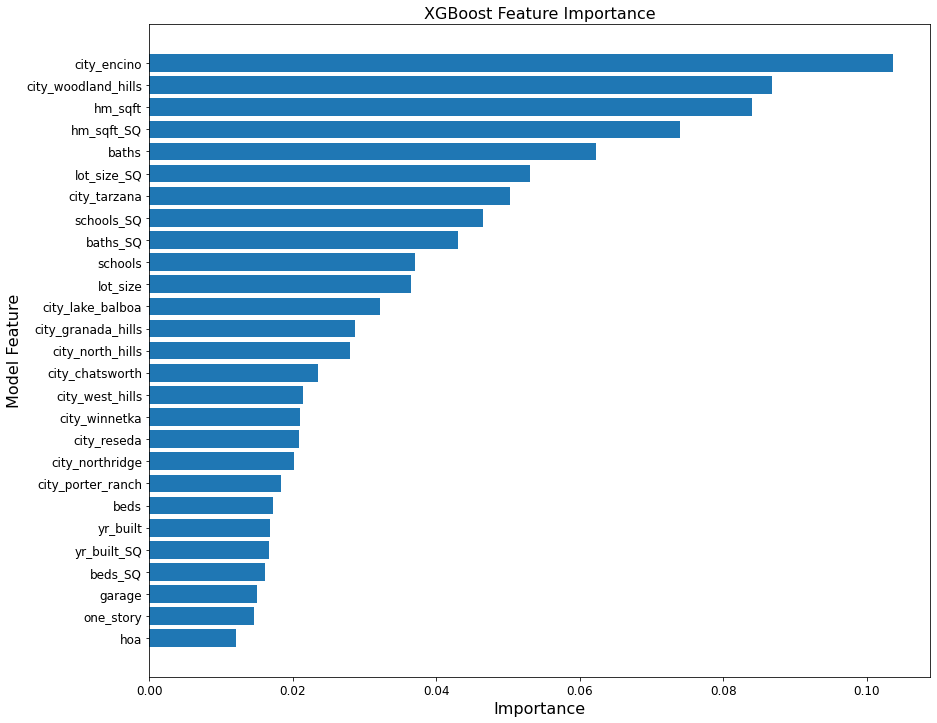

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/Users/georgepappy/opt/anaconda3/envs/metis/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.wa

In [159]:
sorted_idx = model_7.feature_importances_.argsort()
plt.figure(figsize=(14, 12))
plt.barh(X7_cv.columns[sorted_idx], model_7.feature_importances_[sorted_idx])
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel("Importance", fontsize=16)
plt.xticks(fontsize='12')
plt.ylabel("Model Feature", fontsize=16)
plt.yticks(fontsize='12');

In [ ]:
feature_importances = sorted(list(zip(X7_cv.columns, model_7.feature_importances_)), 
                             key=lambda x: x[1],
                             reverse=True)
feature_importances